In [1]:
import os
import sys
from tqdm import tqdm
sys.path.append("..")

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import tensorboard
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from transformers import (WEIGHTS_NAME, AdamW, BertConfig,
                                  BertForTokenClassification, BertTokenizer,
                                  get_linear_schedule_with_warmup)
from src.movientities.models.BertModel import BertNerModel
from src.movientities.data.analyze_dataset import Analyzer
from src.movientities.data.make_dataset import MakeData
from src.movientities.utils.processors import NerPreProcessor

<Figure size 432x288 with 0 Axes>

In [2]:
# Some initializers
train = True
num_train_epochs = 5
train_batch_size = 16
eval_batch_size = 8
# Weight decay for regularization
weight_decay = 0.01
# Now 1 but if batches wont fit RAM can be increased
gradient_accumulation_stepbase
# %10 warm up
warmup_proportion = 0.1
# Adam variables
adam_epsilon = 1e-8
learning_rate = 5e-5
# 16 floating point instead of 32
fp16 = False
if fp16:
    # Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']
    fp16_opt_level
# max seq length (for engtrain.bio since the lengths are pretty short 128 is alright)
max_seq_length = 128
# For gradient clipping
max_grad_norm = 1.0
# For having flexibility over hardware
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Data path
data_dir = "/home/karaz/Desktop/MovieEntityRecognizer/data/modified"
# Tensorboard Name


In [3]:
# For downloading data, doesn't require ssl so if downloaded no need to run it again
# dataset_names = ["engtrain.bio", "engtest.bio", "trivia10k13train.n,bio", "trivia10k13test.bio"]
# (MakeData.download_data(os.path.join("http://groups.csail.mit.edu/sls/downloads/movie", dataset_name) for dataset_name in dataset_names)



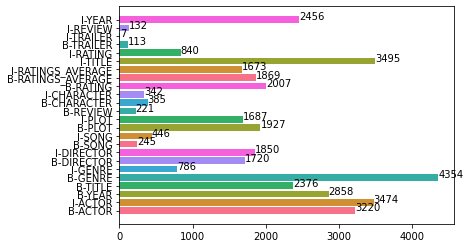

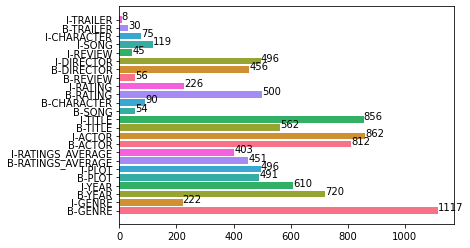

In [4]:
# Count also word frequencies and lengths or sentences
train_labels = Analyzer.count_labels("/home/karaz/Desktop/MovieEntityRecognizer/data/raw/engtrain.bio", without_o=True)
Analyzer.plot_data(train_labels)
test_labels = Analyzer.count_labels("/home/karaz/Desktop/MovieEntityRecognizer/data/raw/engtest.bio", without_o=True)
Analyzer.plot_data(test_labels)

In [5]:
# Get distinct labels
label_list = list(train_labels.keys())
label_list.append("[CLS]")
label_list.append("[SEP]")
label_list.append("O")
num_labels = len(label_list) + 1
print(f"Size of labels of regular dataset: {len(label_list)}\n{label_list}")

Size of labels of regular dataset: 27
['B-ACTOR', 'I-ACTOR', 'B-YEAR', 'B-TITLE', 'B-GENRE', 'I-GENRE', 'B-DIRECTOR', 'I-DIRECTOR', 'B-SONG', 'I-SONG', 'B-PLOT', 'I-PLOT', 'B-REVIEW', 'B-CHARACTER', 'I-CHARACTER', 'B-RATING', 'B-RATINGS_AVERAGE', 'I-RATINGS_AVERAGE', 'I-TITLE', 'I-RATING', 'B-TRAILER', 'I-TRAILER', 'I-REVIEW', 'I-YEAR', '[CLS]', '[SEP]', 'O']


In [6]:
config = BertConfig.from_pretrained("bert-base-cased", num_labels=num_labels, finetuning_task="ner")
tokenizer = BertTokenizer.from_pretrained("bert-base-cased", do_lower_case=False)
model = BertNerModel.from_pretrained("bert-base-cased",
              from_tf = False,
              config = config)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertNerModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertNerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertNerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertNerModel were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.weight', 'c

In [7]:
if train:
    train_instances = NerPreProcessor.get_instances(data_dir, "train")
    num_train_optimization_steps = int(
    len(train_instances) / train_batch_size / gradient_accumulation_steps) * num_train_epochs
    print(f"Number of training steps {num_train_optimization_steps}")
    print(f"Number of training instances {len(train_instances)}")

Number of training steps 1525
Number of training instances 9775


In [8]:
# Pass the model to GPU if any and summary of the model
model.to(device)
print(f"Model is at device {device}")

Model is at device cuda


In [9]:
# Regularization to the weights with weight decay (which is L2 norm in this case)
param_optimizer = list(model.named_parameters())
# The shouldn't be a regularization to layer normalization and bias considering their natures.
no_decay = ['bias','LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

In [10]:
warmup_steps = int(warmup_proportion * num_train_optimization_steps)
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, num_train_optimization_steps)

In [11]:
# for 16 floating point training which will save RAM but may decrease performance, can be used if RAM is not enough
if fp16:
    try:
        from apex import amp
    except ImportError:
        raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
    model, optimizer = amp.initialize(model, optimizer, opt_level=fp16_opt_level)

In [12]:
if train:
    train_features = NerPreProcessor.convert_instances_to_features(
            train_instances, label_list, max_seq_length, tokenizer)

*** Example ***
guid: train-0
tokens: what movies star br ##uce will ##is
input_ids: 101 1184 5558 2851 9304 15776 1209 1548 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
input_mask: 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
*** Example ***
guid: train-1
tokens: show me films with drew bar ##ry ##more from the 1980s
inp

In [13]:
# Extract inputs for converting them to torch.long
all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long).to("cpu")
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long).to("cpu")
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long).to("cpu")
all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long).to("cpu")
all_valid_ids = torch.tensor([f.valid_ids for f in train_features], dtype=torch.long).to("cpu")
all_lmask_ids = torch.tensor([f.label_mask for f in train_features], dtype=torch.long).to("cpu")

In [14]:
# Combine them back into tensor dataset
train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids,all_valid_ids,all_lmask_ids)
train_sampler = RandomSampler(train_data)

In [15]:
# Initialize a DataLoader for putting batches to RAM and from RAM when backpropagation is finished
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)

In [16]:
if train:
    global_step = 0
    nb_tr_steps = 0
    tr_loss = 0
    label_map = {i : label for i, label in enumerate(label_list,1)}
    # Initialize training mode of the model for turning on regularizations such as dropout and L2
    model.train()
    for _ in range(int(num_train_epochs)):
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids, valid_ids,l_mask = batch
            loss = model(input_ids, segment_ids, input_mask, label_ids,valid_ids,l_mask)
            if gradient_accumulation_steps > 1:
                loss = loss / gradient_accumulation_steps
            if fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), max_grad_norm)
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            tr_loss += loss.item()
            nb_tr_examples += input_ids.size(0)
            nb_tr_steps += 1
            if (step + 1) % gradient_accumulation_steps == 0:
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

Iteration:   0%|          | 7/2444 [00:04<26:04,  1.56it/s]


RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 5.93 GiB total capacity; 4.66 GiB already allocated; 61.50 MiB free; 4.70 GiB reserved in total by PyTorch)